In [1]:
import pandas
import numpy
import matplotlib.pyplot as plt
import cv2
import os
import pandas
import numpy
import matplotlib.pyplot as plt
import cv2
import os
import glob


# Project Overview


<img src="images/pld3280-fig-0001-m.jpg" width="800" height="600">

## Part 1. Thresholding the image strips

Load the custom strips into the notebook and threshold them to get the binary images.

In [2]:
def load_gray_image(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray

def equalize_image(image, clip_low=100, clip_high=255):
    equalized = cv2.equalizeHist(image)
    equalized = numpy.clip(equalized, clip_low, clip_high)
    return equalized

def get_image_metadata(image_path):
    # get the image name
    image_name = os.path.basename(image_path)
    # get the metadata for that image
    image_metadata = metadata[metadata["strip_filename"] == image_name]
    return image_metadata

In [3]:
# get a list of all images
images = glob.glob("roi_images/*.png")
print(f"Found {len(images)} images")

# load the metadata
metadata = pandas.read_csv("roi_metadata.csv")

# print the size of the metadata
print(f"Metadata contains {len(metadata)} images")

# print the image metadata for the first image
print(f"Image 0 metadata:")
print(get_image_metadata(images[0]))



meta_df = {"images": images,
           "clip_low": 75, 
           "clip_high": 255, 
           "min_area": 100, 
           "max_area": 1e100, 
           "k0": 2, # kernel dimensions y
           "k1": 5, # kernel dimensions x
           "opening_iterations": 1, 
           "closing_iterations": 3, 
           "threshold_type": "otsu",
           "th_min_value": 0,
            "th_max_value": 255,
           "th_block_size": 15,
           "th_constant": 2,}

for item in meta_df:
    print(item, meta_df[item])

Found 329 images


FileNotFoundError: [Errno 2] No such file or directory: 'roi_metadata.csv'

## Display our custom strips

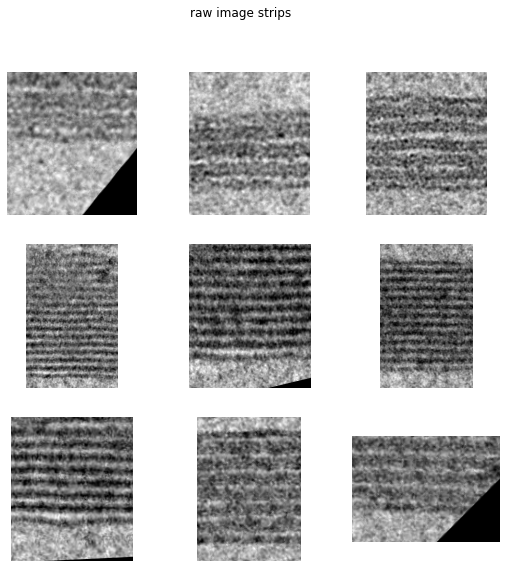

In [4]:
# plot all of the images in a grid
plt.figure(figsize=(9, 9))
plt.suptitle("raw image strips")
for i in range(9):
    plt.subplot(3, 3, i + 1)
    image = load_gray_image(images[i])
    plt.imshow(image, cmap="gray")
    plt.axis("off")

## Display all of the strips, with balanced and clipped scale


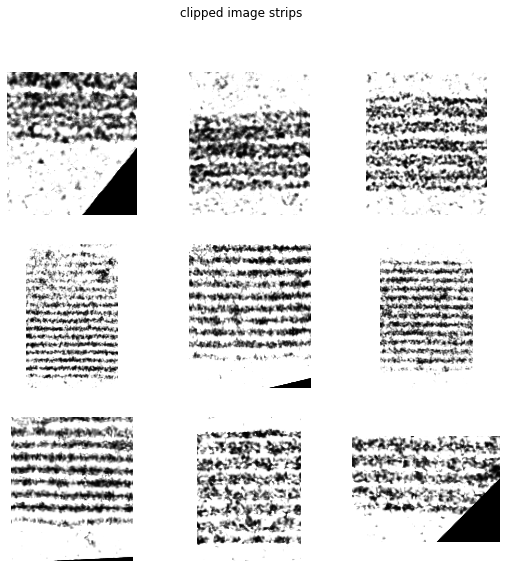

In [5]:
# plot all of the images in a grid
plt.figure(figsize=(9, 9))
plt.suptitle("clipped image strips")
for i in range(9):
    plt.subplot(3, 3, i + 1)
    image = load_gray_image(images[i])
    image = equalize_image(image, clip_low=0, clip_high=130)
    plt.imshow(image, cmap="gray")
    plt.axis("off")

## Threshold the image using the Otsu method

The Otus method is a simple and effective way to threshold an image. It calculates the threshold value based on the histogram of the image. The threshold value is the value that minimizes the intra-class variance of the two classes.

Text(0.5, 1.0, 'Otsu Thresholded Image')

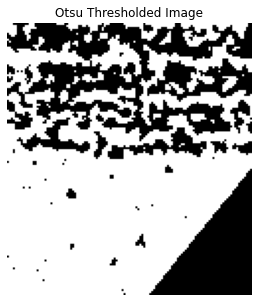

In [6]:
# threshold the image using a smart thresholding technique

clip_low, clip_high = 0, 130

def threshold_image(image, threshold_type=cv2.THRESH_BINARY, block_size=15, constant=2):
    _, thresholded = cv2.threshold(image, 0, 255, threshold_type + cv2.THRESH_OTSU)
    return thresholded

image = load_gray_image(images[0])
equalized = equalize_image(image, clip_low=clip_low, clip_high=clip_high)
thresholded = threshold_image(equalized, threshold_type=cv2.THRESH_BINARY, block_size=15, constant=2)

# plot the thresholded image
plt.figure(figsize=(5, 5))
plt.imshow(thresholded, cmap="gray")
plt.axis("off")
plt.title("Otsu Thresholded Image")

## Cleaning the strips
Our strips are not perfect, so we need to clean them up a bit. We will use morphological operations to remove small noise and fill in small holes.

The main imperfections seem to be in the non-lumen areas. In the non-lumen (darker) areas, we have some small white spots that we need to remove. We can do this by using a morphological opening operation. This operation will remove small white spots in the image.

## Inverted, cleaned, and thresholded strips

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

closing_kernel = np.ones((1, 7), np.uint8)
opening_kernel = np.ones((1, 5), np.uint8)
closing_iterations = 1
opening_iterations = 1
th_low = 0
th_high = 130

base_path = f"./output/trial_{trial_number}/processed_images"

os.makedirs(base_path, exist_ok=True)

# Assuming the function `load_gray_image` and the list `images` are defined elsewhere

def process_test_image(image, th_low=0, th_high=255):
    equalized = cv2.equalizeHist(image)
    # thresholded = cv2.adaptiveThreshold(equalized, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,25, 2)
    _, thresholded = cv2.threshold(image, th_low, th_high, cv2.THRESH_OTSU)

    closing1 = cv2.morphologyEx(thresholded, cv2.MORPH_CLOSE, closing_kernel, iterations=closing_iterations)
    
    opening2 = cv2.morphologyEx(closing1, cv2.MORPH_OPEN, opening_kernel, iterations=opening_iterations)

    return [image, equalized, thresholded, closing1, opening2]

# List to store all processed images
all_images = []

# Process each image and store the results
for image_number in range(9):
    image = load_gray_image(images[image_number])
    processed_images = process_test_image(image, th_low=th_low, th_high=th_high)
    all_images.extend(processed_images)
    
    morphed_image = processed_images[-1]
    
    # threshold the image using a smart thresholding technique
    _, invert_image = cv2.threshold(morphed_image, 0, 255, cv2.THRESH_BINARY_INV)
        
    print(f"Image {image_number} has {np.sum(invert_image == 255)} pixels")

    image_name = f"{base_path}/{images[image_number].split('\\')[-1]}"
    
    print(f"Saving image to {image_name}")
    
    cv2.imwrite(image_name, invert_image)
    

# Plot all the images in a single figure with 9 rows and 6 columns
fig, axes = plt.subplots(9, 5, figsize=(18, 27))

for i, ax in enumerate(axes.flat):
    ax.imshow(all_images[i], cmap='gray')
    ax.axis('off')
    if i % 5 == 0:
        ax.set_title("Original Image")
    elif i % 5 == 1:
        ax.set_title("Equalized Image")
    elif i % 5 == 2:
        ax.set_title("Thresholded Image")
    elif i % 5 == 3:
        ax.set_title("Closed Image")
    elif i % 5 == 4:
        ax.set_title("Opened Image")

plt.tight_layout()
plt.savefig("./report/processed_images.png")
plt.show()



SyntaxError: f-string expression part cannot include a backslash (Temp/ipykernel_31732/523556360.py, line 45)

In [ ]:
import random

# I have 9 images that will be processed. Each will result in a row of 6 images.

# choose a random image
# random.seed(0)
# image_number = random.randint(0, len(images) - 1)
# print(f"Image number: {image_number}")
for image_number in range(9):

    image = load_gray_image(images[image_number])
    equalized = equalize_image(image, clip_low=0, clip_high=100)
    thresholded = threshold_image(equalized, threshold_type=cv2.THRESH_BINARY, block_size=15, constant=2)
    thresholded = cv2.bitwise_not(thresholded)

    # create a custom kernel that is a line with a wider horizontal component, to detect the horizontal lines in the image
    kernel = numpy.ones((1, 3), numpy.uint8)

    # remove small white spots in the image
    closing1 = cv2.morphologyEx(thresholded, cv2.MORPH_CLOSE, kernel, iterations=1)
    opening = cv2.morphologyEx(closing1, cv2.MORPH_OPEN, kernel, iterations=1)
    closing2 = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=1)

    # plot the raw image, the thresholded image, and the opened image
    plt.figure(figsize=(15, 10))

    plt.subplot(1, 6, 1)
    plt.imshow(image, cmap="gray")
    plt.axis("off")
    plt.title("Original Image")

    plt.subplot(1, 6, 2)
    plt.imshow(equalized, cmap="gray")
    plt.axis("off")
    plt.title("Equalized Image")

    plt.subplot(1, 6, 3)
    plt.imshow(thresholded, cmap="gray")
    plt.axis("off")
    plt.title("Thresholded Image")

    plt.subplot(1, 6, 4)
    plt.imshow(closing1, cmap="gray")
    plt.axis("off")
    plt.title("Closed Image 1")

    plt.subplot(1, 6, 5)
    plt.imshow(opening, cmap="gray")
    plt.axis("off")
    plt.title("Opened Image")

    plt.subplot(1, 6, 6)
    plt.imshow(closing2, cmap="gray")
    plt.axis("off")
    plt.title("Closed Image 2")

## Inverted, open, close, open

In [ ]:
import random

# choose a random image
# random.seed(0)
# image_number = random.randint(0, len(images) - 1)
# print(f"Image number: {image_number}")
image_number = 3

image = load_gray_image(images[image_number])
equalized = equalize_image(image, clip_low=0, clip_high=100) # gets rid of the background, the lighter parts of the image
thresholded = threshold_image(equalized, threshold_type=cv2.THRESH_BINARY, block_size=15, constant=2)

# invert so that the membranes are white, and the background is black
thresholded = cv2.bitwise_not(thresholded)

# create a custom kernel that is a line with a wider horizontal component, to detect the horizontal lines in the image

# remove small white spots in the image
opening_kernel = numpy.ones((2, 3), numpy.uint8)
opening1 = cv2.morphologyEx(thresholded, cv2.MORPH_CLOSE, opening_kernel, iterations=2) # opens the image, removes small white spots

closing_kernel = numpy.ones((1, 3), numpy.uint8)
closing1 = cv2.morphologyEx(thresholded, cv2.MORPH_OPEN, closing_kernel, iterations=1) # What is this doing? It is closing the image, removing small black spots

# plot the raw image, the thresholded image, and the opened image
plt.figure(figsize=(15, 10))

plt.subplot(1, 5, 1)
plt.imshow(image, cmap="gray")
plt.axis("off")
plt.title("Original Image")

plt.subplot(1, 5, 2)
plt.imshow(equalized, cmap="gray")
plt.axis("off")
plt.title("Equalized Image")

plt.subplot(1, 5, 3)
plt.imshow(thresholded, cmap="gray")
plt.axis("off")
plt.title("Thresholded Image")

plt.subplot(1, 5, 4)
plt.imshow(opening1, cmap="gray")
plt.axis("off")
plt.title("Opened Image")

plt.subplot(1, 5, 5)
plt.imshow(closing1, cmap="gray")
plt.axis("off")
plt.title("Closed Image 1")



## now we need to create contours for the objects, and filter out the small ones


In [ ]:

for image_number in range(9):

    image = load_gray_image(images[image_number])
    
    
    image = load_gray_image(images[image_number])
    equalized = equalize_image(image, clip_low=0, clip_high=100)
    thresholded = threshold_image(equalized, threshold_type=cv2.THRESH_BINARY, block_size=15, constant=2)
    thresholded = cv2.bitwise_not(thresholded)

    # create a custom kernel that is a line with a wider horizontal component, to detect the horizontal lines in the image
    kernel = numpy.ones((1, 3), numpy.uint8)

    # remove small white spots in the image
    closing1 = cv2.morphologyEx(thresholded, cv2.MORPH_CLOSE, kernel, iterations=1)
    opening = cv2.morphologyEx(closing1, cv2.MORPH_OPEN, kernel, iterations=1)
    closing2 = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=1)

    # find the contours in the image
    contours, _ = cv2.findContours(closing2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # filter by area
    min_area = 10
    max_area = 1e100
    filtered_contours = [c for c in contours if min_area < cv2.contourArea(c) < max_area]

    # draw the contours on the image
    contour_image = numpy.zeros_like(image)
    cv2.drawContours(contour_image, filtered_contours, -1, (255, 255, 255), 1)

    # create rgb copy of original image
    rgb_image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    # create a red contour image
    contour_image = numpy.zeros_like(rgb_image)

    cv2.drawContours(contour_image, filtered_contours, -1, (255, 0, 0), 1)

    # create an image with the RGB image and the contour image overlaid
    overlay = cv2.addWeighted(rgb_image, 0.5, contour_image, 0.5, 0)

    # plot the rgb_image, the contour image, and then the overlay
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 4, 1)
    plt.imshow(rgb_image)
    plt.axis("off")
    plt.title("Image")

    plt.subplot(1, 4, 2)
    plt.imshow(closing2, cmap="gray")
    plt.axis("off")
    plt.title("Closing Image")

    plt.subplot(1, 4, 3)
    plt.imshow(contour_image)
    plt.axis("off")
    plt.title("Contour Image")

    plt.subplot(1, 4, 4)
    plt.imshow(overlay)
    plt.axis("off")
    plt.title("Overlay Image")

    plt.savefig(f"output/contours_{image_number}.png")

## Function to do all the things


In [ ]:
def load_gray_image(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray

def equalize_image(image, clip_low=100, clip_high=255):
    equalized = cv2.equalizeHist(image)
    equalized = numpy.clip(equalized, clip_low, clip_high)
    return equalized

def process_image_strip(image_path: str, metadata: dict) -> dict:
    # load the image
    image = load_gray_image(image_path)

    print(f"Processing {image_path}")
    # equalize the image
    equalized = equalize_image(image, metadata["clip_low"], metadata["clip_high"])


    # threshold the image
    if metadata["threshold_type"] == "otsu":
        _, thresholded = cv2.threshold(image, metadata["th_min_value"], metadata["th_max_value"], cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    else:
        thresholded = cv2.adaptiveThreshold(equalized, metadata["th_max_value"], cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, metadata["th_block_size"], metadata["th_constant"])
        
    # create a custom kernel that is a line with a wider horizontal component, to detect the horizontal lines in the image
    kernel = numpy.ones((metadata["k0"], metadata["k1"]), numpy.uint8)

    # remove small white spots in the image
    opening = cv2.morphologyEx(thresholded, cv2.MORPH_OPEN, kernel, iterations=metadata["opening_iterations"])
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=metadata["closing_iterations"])

    # find the contours in the image
    contours, _ = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # filter by area
    filtered_contours = [c for c in contours if metadata["min_area"] < cv2.contourArea(c) <  metadata["max_area"]]

    return {"image": image, "equalized": equalized, "thresholded": thresholded, "closing": closing, "filtered_contours": filtered_contours, "raw_image": cv2.imread(image_path)}


In [ ]:
trial_number = 0
base_filepath =  f"output/trial_{trial_number}"
equalized_filepath = f"{base_filepath}/equalized"
contours_filepath =  f"{base_filepath}/contours"
comparison_filepath =  f"{base_filepath}/comparison"
overlay_filepath =  f"{base_filepath}/overlay"
thresholded_filepath =  f"{base_filepath}/thresholded"
strips_filepath = f"roi_images"
output_strips_filepath = f"{base_filepath}/strips"
images = glob.glob(f"{strips_filepath}/*.png")

contour_thickness = -1 # -1 to have the contour filled

# ensure that the directories exist
os.makedirs(contours_filepath, exist_ok=True)
os.makedirs(comparison_filepath, exist_ok=True)
os.makedirs(overlay_filepath, exist_ok=True)
os.makedirs(thresholded_filepath, exist_ok=True)
os.makedirs(output_strips_filepath, exist_ok=True)
os.makedirs(equalized_filepath, exist_ok=True)

# load the roi_metadata 
metadata = pandas.read_csv("roi_metadata.csv")

# save it to the output directory
metadata.to_csv(f"{base_filepath}/roi_metadata.csv", index=False)

# - image name
# - equalize histogram parameters, clip_low, clip_high
# - Otsu thresholding parameters
# - contour min and max area used for thresholding
# # - opening and closing kernel size and iterations
files_str = ", ".join(images)
meta_df = {"images": files_str,
           "clip_low": 0, 
           "clip_high": 130, 
           "min_area": 10, 
           "max_area": 1e100, 
           "k0": 1, # kernel dimensions y
           "k1": 3, # kernel dimensions x
           "opening_iterations": 1, 
           "closing_iterations": 3, 
           "threshold_type": "otsu",
           "th_min_value": 0,
            "th_max_value": 255,
           "th_block_size": 15,
           "th_constant": 2,}

# write out the metadata as a json file
import json
with open(f"{base_filepath}/processing_metadata.json", "w") as f:
    f.write(json.dumps(meta_df, indent=4))


for filename in images[:10]:
    print(filename)

    # save to output strips
    cv2.imwrite(f"{output_strips_filepath}/{os.path.basename(filename)}", cv2.imread(filename))
    
    processed = process_image_strip(filename, meta_df)
    
    print(processed["closing"].shape)
    print(processed["image"].shape)
    
    image_name = os.path.basename(filename)
    cv2.imwrite(f"{thresholded_filepath}/{image_name}", processed["thresholded"])

    image = processed["image"]
    cv2.imwrite(f"{equalized_filepath}/{image_name}", image)

    filtered_contours = processed["filtered_contours"]
    raw_image = processed["raw_image"]    
    raw_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)

    # draw the contours on the image
    contour_image = numpy.zeros_like(image)
    cv2.drawContours(contour_image, filtered_contours, -1, (255, 255, 255), contour_thickness)

    # save the contour image
    cv2.imwrite(f"{contours_filepath}/{image_name}", contour_image)

    # create rgb copy of original image
    rgb_image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    # # create a red contour image
    contour_image = numpy.zeros_like(rgb_image)

    cv2.drawContours(contour_image, filtered_contours, -1, (0, 0, 255), contour_thickness)

    # create an image with the RGB image and the contour image overlaid
    overlay = cv2.addWeighted(rgb_image, 0.5, contour_image, 0.5, 0)
    
    cv2.imwrite(f"{overlay_filepath}/{image_name}", overlay)
    
    # plot the rgb_image, the contour image, and then the overlay. The figsize should be wider than it is tall
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 4, 1)
    plt.imshow(raw_image)
    plt.axis("off")
    plt.title("Raw Image")
    
    plt.subplot(1, 4, 2)
    plt.imshow(rgb_image)
    plt.axis("off")
    plt.title("Image")

    plt.subplot(1, 4, 3)
    plt.imshow(contour_image)
    plt.axis("off")
    plt.title("Contour Image")

    plt.subplot(1, 4, 4)
    plt.imshow(overlay)
    plt.axis("off")
    plt.title("Overlay Image")

    plt.savefig(f"{comparison_filepath}/{image_name}")
    
